# Classification Project: What Causes Telco Churn?

## --- Pipeline phase 1: Planning: ---

 ### In this notebook we will explore where drivers for churn or attrition might be based on a dataset snapshot of customers for a telecommunications service.  We will investigate differences between groups of customers and what might make one group or class different from another, and if that has any bearing on their propensity to leave the company.
 
 ### Please reference data_dictionary.py for explicit details on features.

In [139]:
# setting up our environment: 

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier


from acquire import get_telco_data
from telco_prep import *
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter


from scipy.stats import ttest_ind as ttest
from scipy.stats import pearsonr

## --- Pipeline phase 2: Acquisition: ---

In [140]:
# call our function to pull our dataframe using mySQL:
df = get_telco_data()

## --- Pipeline Phase 3: Preparation: ---

In [142]:
# call function to prepare dataframe based on parameters outlined
# in prepare.py and curriculum instructions
df = prep_telco_data(df)

In [147]:
def drop_totals(df):
    df = df[pd.notna(df.total_charges)]
    return df
    


In [148]:
df = drop_totals(df)
train = drop_totals(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4922 entries, 463 to 3587
Data columns (total 17 columns):
senior_citizen            4922 non-null int64
tenure                    4922 non-null int64
contract_type_id          4922 non-null int64
payment_type_id           4922 non-null int64
monthly_charges           4922 non-null float64
total_charges             4922 non-null float64
tenure_year               4922 non-null int64
phone_id                  4922 non-null int64
household_type_id         4922 non-null int64
streaming_services        4922 non-null int64
online_security_backup    4922 non-null int64
gender_e                  4922 non-null int64
device_protection_e       4922 non-null int64
tech_support_e            4922 non-null int64
paperless_billing_e       4922 non-null int64
int_type_id               4922 non-null int64
churn                     4922 non-null int64
dtypes: float64(2), int64(15)
memory usage: 692.2 KB


## --- Pipeline phase 4: Exploration: ---

In [166]:
# Numeric Scaling: scale the monthly_charges and total_charges data. 
# Make sure that the parameters for scaling are learned from the training data set.

# split the dataframe
X = df.drop(['churn'], axis = 1)
y = df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)

#concatinate our X and y together to make a single test and train df
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# scale our monthly and total charges
scaler = MinMaxScaler()
scaler.fit(train[['monthly_charges', 'total_charges']])

train[['monthly_charges', 'total_charges']] = scaler.transform(train[['monthly_charges', 'total_charges']])
test[['monthly_charges', 'total_charges']] = scaler.transform(test[['monthly_charges', 'total_charges']])


In [167]:
X_train = X_train.drop(columns=(['gender_e', 'phone_id', 'streaming_services', 'online_security_backup',
                                  'senior_citizen',]))
X_test = X_test.drop(columns=(['gender_e', 'phone_id', 'streaming_services', 'online_security_backup',
                                  'senior_citizen',]))

In [168]:
logit = LogisticRegression(C=1, class_weight='balanced', random_state=123, solver='newton-cg')

In [169]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=123,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [170]:
print('Coefficient1: \n', logit.coef_)
print('Intercept1: \n', logit.intercept_)

Coefficient1: 
 [[-7.53380741e-02 -6.99276269e-01 -1.57450687e-01  2.50413102e-03
   2.39529797e-04  3.50316356e-01 -8.27884594e-02 -3.62627785e-03
  -2.28611066e-01  3.40781651e-01  7.61680314e-01]]
Intercept1: 
 [0.62501913]


In [171]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

print('Accuracy of Logistic Regression classifier  on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier  on training set: 0.74


In [177]:
print(confusion_matrix(y_train, y_pred))

tpp = confusion_matrix(y_train, y_pred)

print(tpp[1][1] / (tpp[1][1] + tpp[1][0]))


[[2610 1015]
 [ 242 1055]]
0.8134155744024673


In [173]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3625
           1       0.51      0.81      0.63      1297

   micro avg       0.74      0.74      0.74      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.74      0.76      4922



In [174]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.73


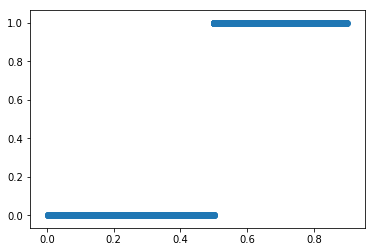

In [179]:
y_pred_proba = [i[1] for i in y_pred_proba]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)